In [77]:
"""
    Notebook on medical image registration

    Author : Simon Queric
    Date : 2024-07-25
    Sources : https://matthew-brett.github.io/teaching/mutual_information.html 
"""


import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import pystrum
# import neurite as ne
from monai.losses import (
    GlobalMutualInformationLoss,
    BendingEnergyLoss,
    DiffusionLoss)
from monai.transforms import BorderPad
from utils import *

## Classical image Registration

Image registration consists in finding change of coordinates to put two images in spatial correspondance.

Formally, if we have two images $A$ and $B$, and given a similarity measure $S$ we want to find a transformation $T^*$  so that : 

$$ T^* = \text{argmax}_{T \in \mathcal{T}} \mathcal{S}(A, T(B)) $$

This is an optimization problem.

More concretely, we can chose $\mathcal{T}$ as the set of affine transformation. In 2D, it corresponds to the following mapping (in homogeneous coordinates) : 

 $$ \begin{pmatrix} u \\ v \\ 1 \end{pmatrix} = \begin{pmatrix} a_{11} & a_{12} & a_{13} \\  a_{21} & a_{22} & a_{23} \\ 0 & 0 & 1 \end{pmatrix} 
    \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}$$

In [94]:
img = plt.imread("brain.jpg")
img = img[::3,::3]
img = img[None,None]
img = torch.Tensor(img)
# img = image
transform = BorderPad(spatial_border=[0, 0, 50])
img = transform(img)
angle = np.pi/4 * np.random.uniform(-1, 1)
rot = Deformation(angle=angle, dx=0.1, dy=0.0)
m_image, _ = rot(img)

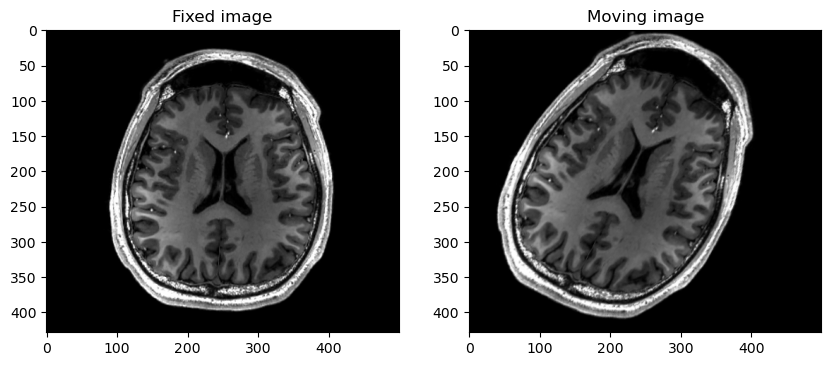

In [95]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img[0, 0], cmap="gray")
# ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(m_image[0, 0].detach().numpy(), cmap="gray")
# ax[1].axis('off')
ax[1].set_title("Moving image")
plt.show()

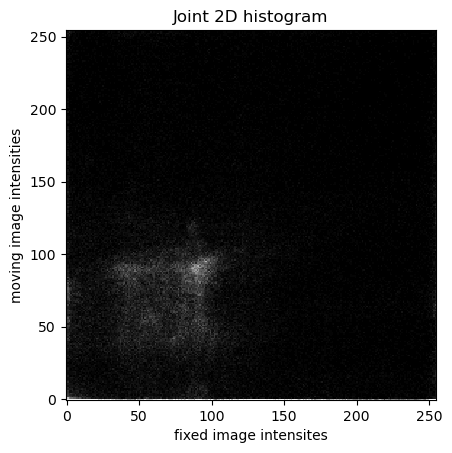

In [96]:
x = img.ravel()
y = m_image.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
plt.title("Joint 2D histogram")
plt.xlabel("fixed image intensites")
plt.ylabel("moving image intensities")
plt.show()

In [97]:
reg = AffineRegistration()
m_image, _ = rot(img)
pred, _ = reg(m_image)
m_image = m_image.detach()
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-2)
criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
# criterion = GlobalMutualInformationLoss(kernel_type="b-spline")

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


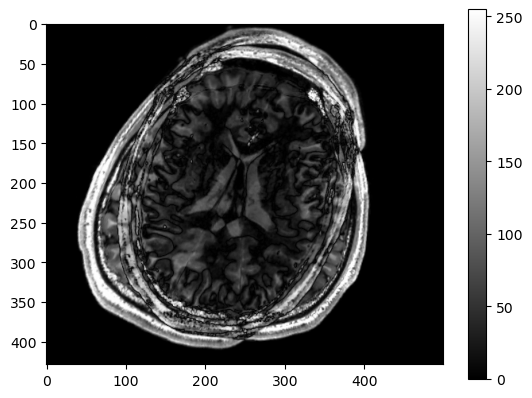

In [98]:
plt.imshow(torch.abs(img-m_image)[0, 0], cmap="gray")
plt.imshow(torch.abs(img[0,0] - m_image[0,0]), cmap="gray")
plt.colorbar()

In [99]:
def dice_loss(x, y):
    return 1 - (((2*x*y).sum()+1e-3) / (x.sum() + y.sum()+1e-3)) 
energy_loss = BendingEnergyLoss()

In [100]:
N_ITER = 400
losses = []
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(m_image) #.requires_grad_(True)
    loss = criterion(pred, img) #+ dice_loss(pred, img) #GlobalMutualInformationLoss()(pred, img)
    # loss+= energy_loss(ddf.permute(0, -1, 1, 2)) #dice_loss(pred, img) 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 400/400 [00:02<00:00, 142.23it/s]


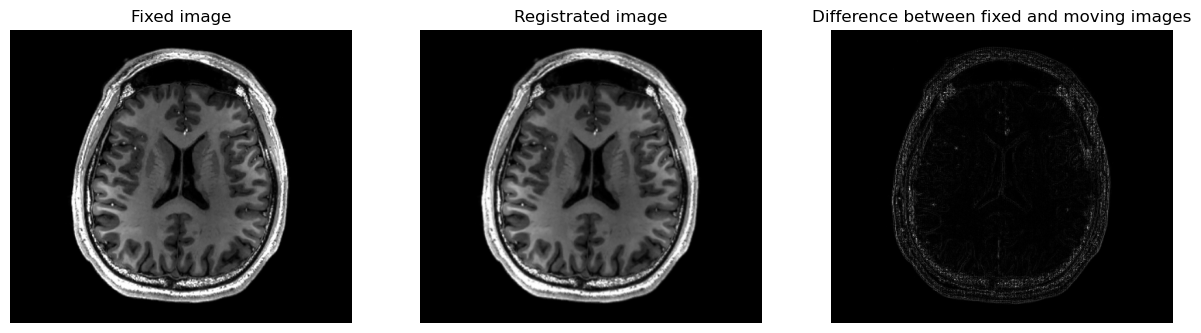

In [107]:
pred, _ = reg(m_image)
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(pred[0, 0].detach(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("Registrated image")
ax[2].imshow(torch.abs(img-pred.detach())[0, 0], cmap="gray")
ax[2].axis('off')
ax[2].set_title("Difference between fixed and moving images")
plt.show()

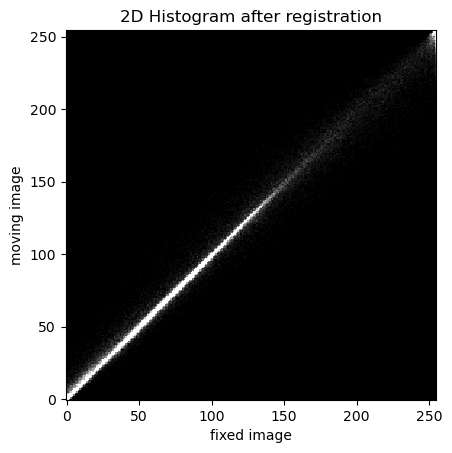

In [102]:
x = img.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, ls="", marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
plt.title("2D Histogram after registration")
plt.xlabel("fixed image")
plt.ylabel("moving image")
plt.show()

In [103]:
print("Absolute error : {:.3f}".format(float(torch.abs(img-pred.detach()).mean() / torch.abs(img).mean())))

Absolute error : 0.035


In [104]:
t = rot.affine_transform
tinv = list(reg.parameters())[0].data
T = torch.eye(3)
Tinv = torch.eye(3)
 
Tinv[:2] = tinv
T[:2] = t

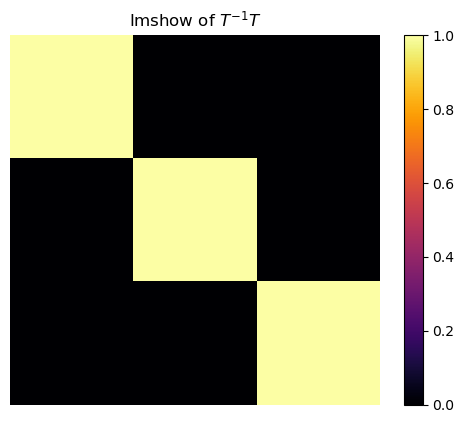

In [105]:
plt.imshow(Tinv@T, cmap="inferno")
plt.title("Imshow of $T^{-1}T$")
plt.axis("off")
plt.colorbar()
plt.show()

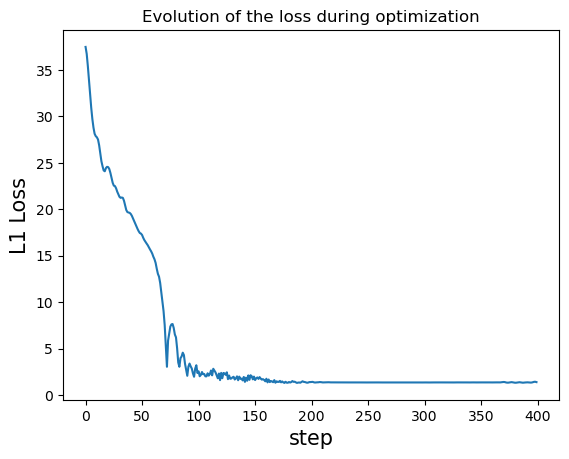

In [106]:
plt.plot(losses)
plt.title("Evolution of the loss during optimization")
plt.xlabel("step", fontsize=15)
plt.ylabel("L1 Loss", fontsize=15)
plt.show()

In [87]:
img = plt.imread("brain.jpg")
img = img[::3,::3]
img = img[None,None]
img = torch.Tensor(img)
transform = BorderPad(spatial_border=[0, 0, 50])
img = transform(img)

angle = np.pi/8 * np.random.uniform(-1, 1)
rot = Deformation(angle=angle, dx=0.2, dy=0.0)
m_image, _ = rot(img)
m_image = m_image

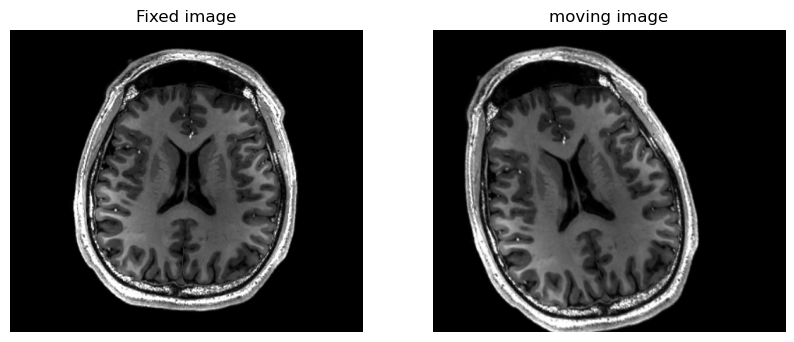

In [88]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(m_image[0, 0].detach().numpy(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("moving image")
plt.show()

In [89]:
reg = AffineRegistration()
m_image, _ = rot(img)
m_image= m_image
pred, _ = reg(m_image)
m_image = m_image.detach()
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-2)
criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
# criterion = GlobalMutualInformationLoss(kernel_type="b-spline")

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


Text(0, 0.5, 'Moving image intensity')

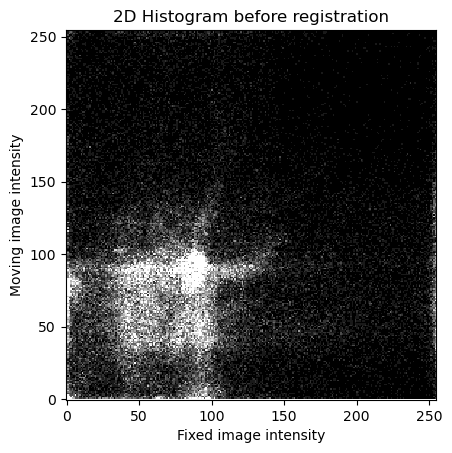

In [90]:
x = img.ravel()
y = m_image.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=10)
plt.title("2D Histogram before registration")
plt.xlabel("Fixed image intensity")
plt.ylabel("Moving image intensity")

In [91]:
N_ITER = 400
losses = []
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(m_image) #.requires_grad_(True)
    loss = criterion(pred, img) #+ dice_loss(pred, img) #GlobalMutualInformationLoss()(pred, img)
    # loss+= energy_loss(ddf.permute(0, -1, 1, 2)) #dice_loss(pred, img) 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 400/400 [00:02<00:00, 160.39it/s]


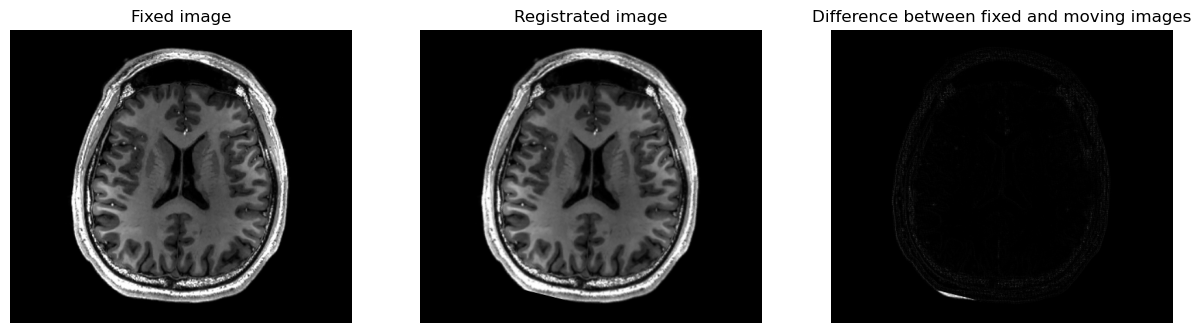

In [93]:
pred, _ = reg(m_image)
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(pred[0, 0].detach(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("Registrated image")
ax[2].imshow(torch.abs(img-pred.detach())[0, 0], cmap="gray")
ax[2].axis('off')
ax[2].set_title("Difference between fixed and moving images")
plt.show()

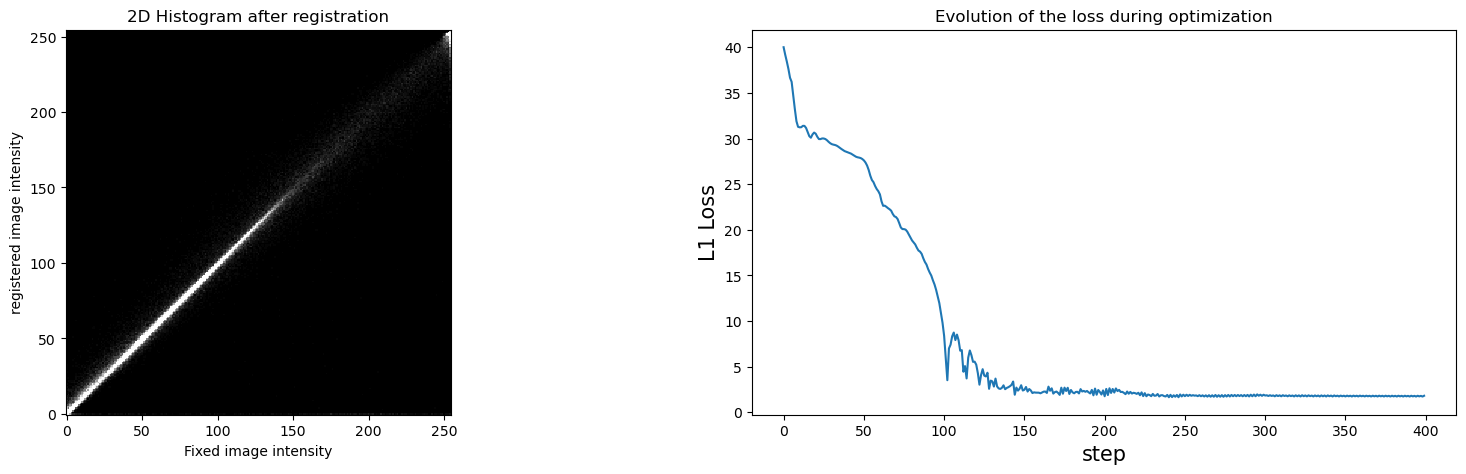

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
x = img.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, ls="", marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
ax[0].imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
ax[0].set_title("2D Histogram after registration")
ax[0].set_xlabel("Fixed image intensity")
ax[0].set_ylabel("registered image intensity")
ax[1].plot(losses)
ax[1].set_title("Evolution of the loss during optimization")
ax[1].set_xlabel("step", fontsize=15)
ax[1].set_ylabel("L1 Loss", fontsize=15)
plt.show()

### Multimodal registration by Mutual Information maximization

In [42]:
t1_img = nib.load("../mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz")
t1_data = t1_img.get_fdata()
t2_img = nib.load("../mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t2_tal_nlin_sym_09a.nii.gz")
t2_data = t2_img.get_fdata() 

In [43]:
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
transform = BorderPad(spatial_border=[0, 20, 20])
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
# transform = BorderPad(spatial_border=[0, 20, 20])
t1_slice.shape

(197, 233)

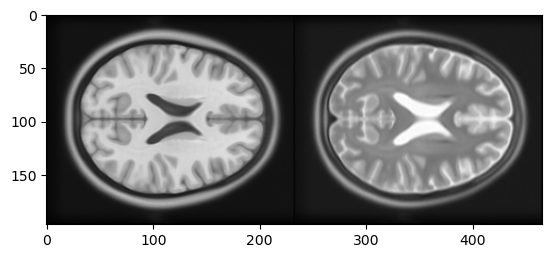

In [44]:
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)), cmap="gray")
plt.show()
t1_slice = torch.Tensor(t1_slice[None, None])
t2_slice = torch.Tensor(t2_slice[None, None])


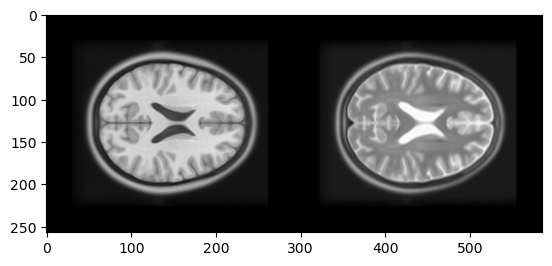

In [45]:
transform = BorderPad(spatial_border=[0, 30, 30])
t1_slice = transform(t1_slice)
t2_slice = transform(t2_slice)
plt.imshow(np.hstack((t1_slice[0,0], t2_slice[0,0])), cmap="gray")
plt.show()

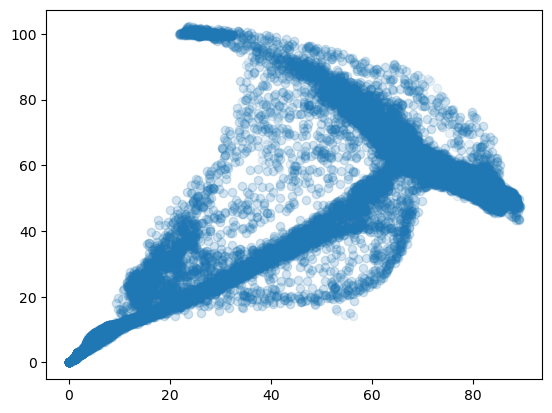

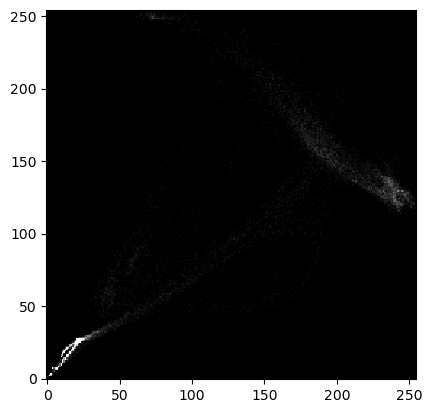

In [46]:
x = t1_slice.ravel()
y = t2_slice.ravel()
plt.plot(x, y, ls="", marker="o", alpha=0.1)
plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=100)
plt.show()

In [47]:
N_ITER = 500
reg = AffineRegistration()
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss() #
criterion = torch.nn.MSELoss()
criterion = GlobalMutualInformationLoss(kernel_type="b-spline")
diffusion_loss = DiffusionLoss()

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


In [48]:
t1_slice.shape

torch.Size([1, 1, 257, 293])

In [49]:
angle = np.pi/6
a, b = np.cos(angle), np.sin(angle)
transform = torch.Tensor( [[[a, -b, 0.1],
                           [b, a, 0.0]]])
warping = F.affine_grid(transform, size=t1_slice.shape, align_corners=True)
t2_m = F.grid_sample(t2_slice, warping, mode="bilinear", align_corners=True)

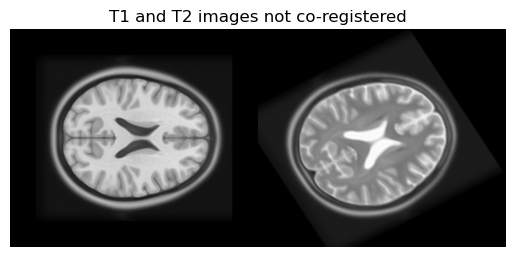

In [50]:
t1_slice.shape
t2_m = F.grid_sample(t2_slice, warping, mode="bilinear", align_corners=True)
t2_m = t2_m.detach()
plt.imshow(np.hstack((t1_slice[0,0], t2_m[0,0])), cmap="gray")
plt.axis("off")
plt.title("T1 and T2 images not co-registered")
plt.show()

In [51]:
losses = []
# best_loss = torch.inf
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(t2_m) #.requires_grad_(True)
    loss = criterion(pred, t1_slice) #dice_loss(pred, img) 
    # loss += diffusion_loss(ddf.permute(0, -1, 1, 2))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 500/500 [01:45<00:00,  4.75it/s]


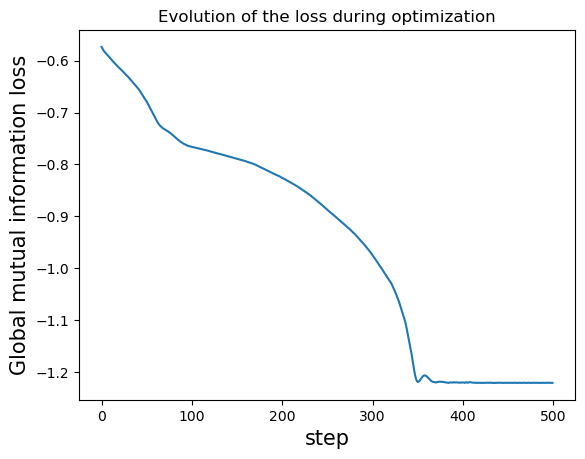

In [52]:
plt.plot(losses)
plt.title("Evolution of the loss during optimization")
plt.xlabel("step", fontsize=15)
plt.ylabel("Global mutual information loss", fontsize=15)
plt.show()

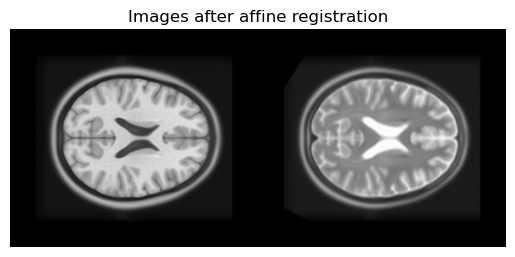

In [53]:
plt.imshow(np.hstack((t1_slice[0,0], pred.detach().numpy()[0,0])), cmap="gray")
plt.axis("off")
plt.title("Images after affine registration")
plt.show()

Text(0, 0.5, 'Moving image intensity')

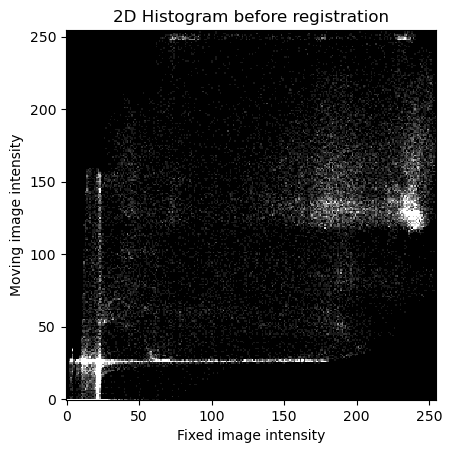

In [54]:
x = t1_slice.ravel()
y = t2_m.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=10)
plt.title("2D Histogram before registration")
plt.xlabel("Fixed image intensity")
plt.ylabel("Moving image intensity")

Text(0, 0.5, 'Registered image intensity')

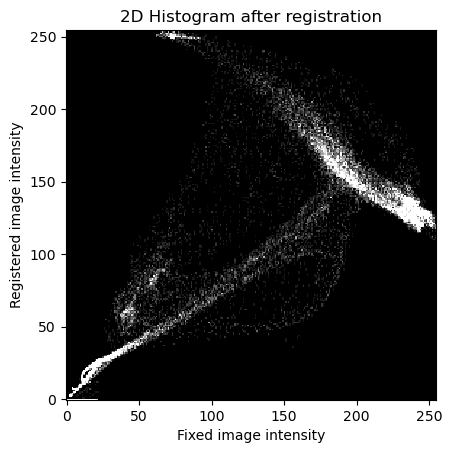

In [55]:
x = t1_slice.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=10)
plt.title("2D Histogram after registration")
plt.xlabel("Fixed image intensity")
plt.ylabel("Registered image intensity")

In [56]:
print(list(reg.parameters()))

[Parameter containing:
tensor([[[ 0.8659,  0.4992, -0.0866],
         [-0.4997,  0.8665,  0.0499]]], requires_grad=True)]


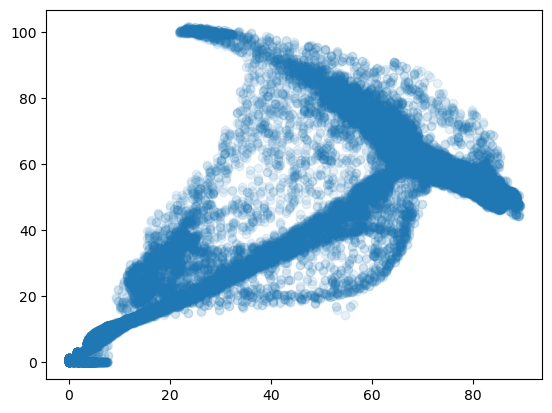

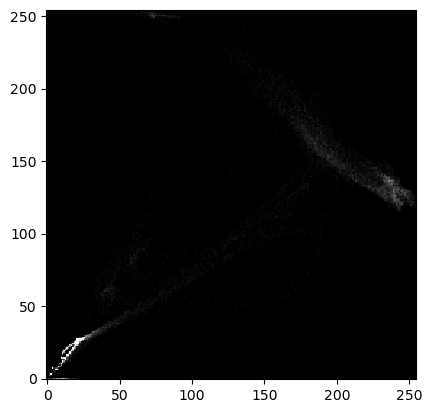

In [57]:
x = t1_slice.ravel()
y = pred.detach().ravel()
plt.plot(x, y, ls="", marker="o", alpha=0.1)
plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=100)
plt.show()